<a href="https://colab.research.google.com/github/akruah/Time-Series-Anomaly-Detection/blob/main/Pytorch_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install pytorch-lightning
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
import pandas as pd
from csv import DictWriter
import csv
import os
from IPython.display import FileLink
import numpy as np
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from torchmetrics.functional import accuracy, auroc
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
)
from multiprocessing import cpu_count
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [ ]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 16, 10
tqdm.pandas()

In [ ]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

Load Data

In [ ]:
df = pd.read_csv('synthetic_iot-2.csv', parse_dates=['time'])
df.head()

,time,zone,sensor_id,temperature,humidity,vibration,pressure,gas_levels,conveyor_speed,forklift_movement,stock_level_changes,order_processing_time,is_anomaly,anomaly_type
0,2023-01-13,1,1,24.502666,33.654448,-0.348107,1012.655508,0.035897,1.467677,3,4.0,25.121717,False,NaN
1,2023-01-13,1,2,25.092322,47.346110,0.370044,1014.897917,0.018983,1.549285,2,9.0,24.177530,False,NaN
2,2023-01-13,1,3,23.282003,32.433724,-0.078701,1009.799881,0.035979,1.591975,4,8.0,42.419862,False,NaN
3,2023-01-13,1,4,21.265561,57.947436,-0.985699,1012.194451,0.040192,1.634519,8,11.0,29.110826,False,NaN
4,2023-01-13,1,5,21.608196,51.941924,0.550544,1009.088751,0.046229,1.680500,4,7.0,22.294487,False,NaN


In [ ]:
df['time'] = pd.to_datetime(df['time'])

In [ ]:
df.head()

,time,zone,sensor_id,temperature,humidity,vibration,pressure,gas_levels,conveyor_speed,forklift_movement,stock_level_changes,order_processing_time,is_anomaly,anomaly_type
0,2023-01-13,1,1,24.502666,33.654448,-0.348107,1012.655508,0.035897,1.467677,3,4.0,25.121717,False,NaN
1,2023-01-13,1,2,25.092322,47.346110,0.370044,1014.897917,0.018983,1.549285,2,9.0,24.177530,False,NaN
2,2023-01-13,1,3,23.282003,32.433724,-0.078701,1009.799881,0.035979,1.591975,4,8.0,42.419862,False,NaN
3,2023-01-13,1,4,21.265561,57.947436,-0.985699,1012.194451,0.040192,1.634519,8,11.0,29.110826,False,NaN
4,2023-01-13,1,5,21.608196,51.941924,0.550544,1009.088751,0.046229,1.680500,4,7.0,22.294487,False,NaN


In [ ]:
df.isna().sum()

,0
time,0
zone,0
sensor_id,0
temperature,0
humidity,0
vibration,0
pressure,0
gas_levels,0
conveyor_speed,0
forklift_movement,0


In [ ]:
df[['temperature', 'humidity', 'vibration', 'pressure', 'gas_levels', 'conveyor_speed',
    'forklift_movement', 'stock_level_changes',
    'order_processing_time']].describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,180000.0,22.148810,2.491116,12.644793,20.584537,22.034987,23.502313,45.676062
humidity,180000.0,50.320274,11.875282,30.000138,40.133964,50.228769,60.297892,99.258011
vibration,180000.0,0.226606,0.562009,-2.196018,-0.133761,0.206207,0.552032,5.227308
pressure,180000.0,1012.992313,4.994122,989.780678,1009.615851,1012.988675,1016.363682,1034.582715
gas_levels,180000.0,0.032535,0.026016,0.010001,0.020151,0.030262,0.040377,0.347643
conveyor_speed,180000.0,1.491990,0.215904,0.301501,1.361125,1.498071,1.633509,2.347386
forklift_movement,180000.0,4.945283,2.294122,0.000000,3.000000,5.000000,6.000000,18.000000
stock_level_changes,180000.0,9.999006,3.178023,0.000000,8.000000,10.000000,12.000000,26.853142
order_processing_time,180000.0,30.354493,6.126726,8.799596,26.666911,30.064205,33.507084,110.798894


In [ ]:
# df2.anomaly_type.value_counts().plot(kind='bar')
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
df['anomaly_type'].value_counts()

,count
anomaly_type,
high_humidity,2324
temperature_spike,2270
vibration_shock,2264
gas_leak,2249
inefficient_routing,2240
inventory_mismatch,2207
unauthorized_access,2179
equipment_failure,2177


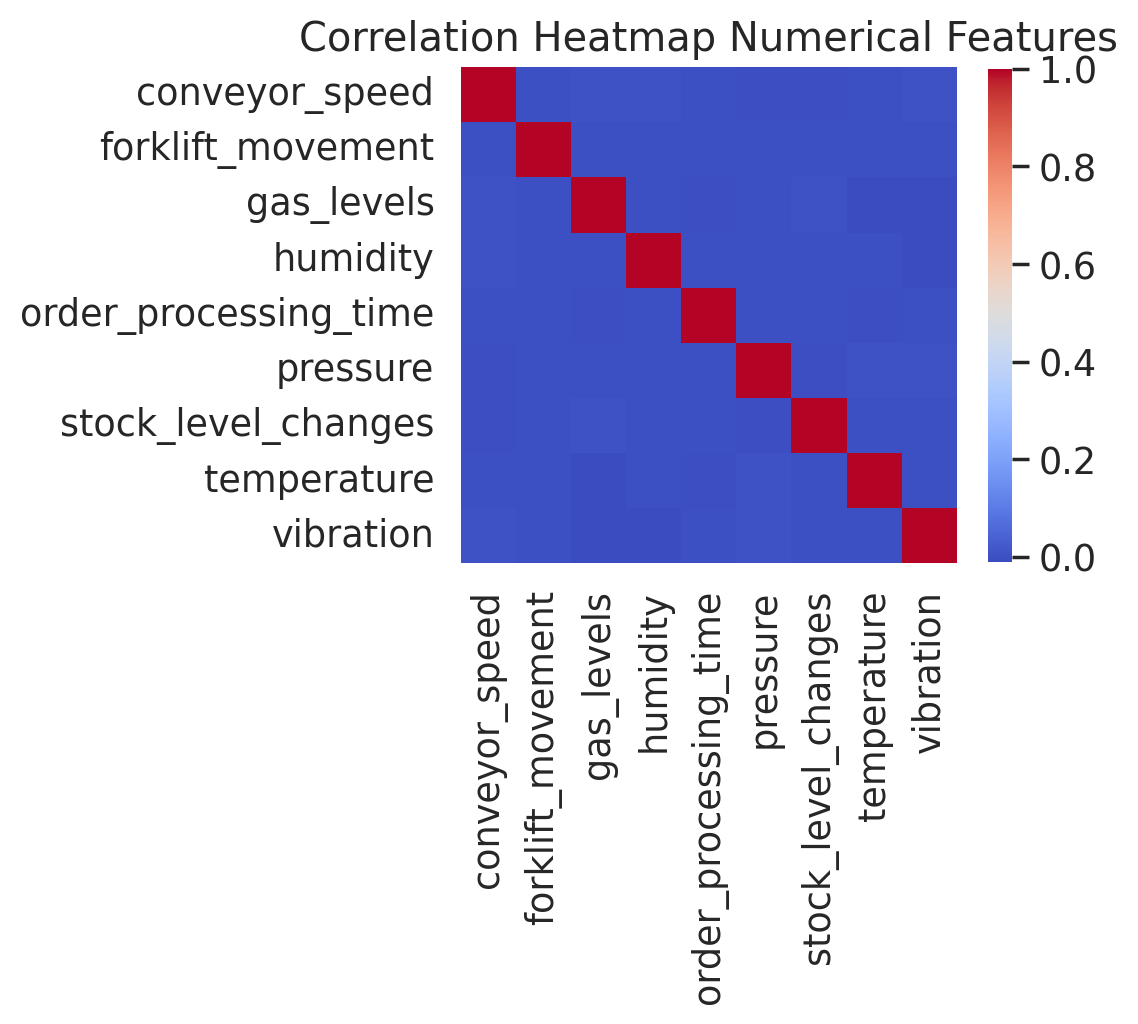

In [ ]:
# Calculate Correlation Matrix
numerical_features = df.select_dtypes(include=np.number).columns
numerical_features = numerical_features.difference(['zone', 'sensor_id'])
corr_matrix = df[numerical_features].corr()

plt.figure(figsize=(4, 4))
sns.heatmap(corr_matrix, annot=False, fmt=".2f",
            cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap Numerical Features')
plt.show()

Removing Outliers

In [ ]:

def remove_outliers_iqr(df, columns, whisker_width=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - whisker_width * IQR
        upper_bound = Q3 + whisker_width * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

outlier_cols = ['temperature', 'pressure', 'vibration',
                'stock_level_changes', 'order_processing_time',
                'humidity', 'gas_levels', 'forklift_movement', 'conveyor_speed']
df_no_outliers = remove_outliers_iqr(df.copy(), outlier_cols)

In [ ]:
df = df_no_outliers.copy()

Handling Missing Values

In [ ]:
df['anomaly_type'].fillna('No Anomaly', inplace=True)

df.isnull().sum()

,0
time,0
zone,0
sensor_id,0
temperature,0
humidity,0
vibration,0
pressure,0
gas_levels,0
conveyor_speed,0
forklift_movement,0


Encoding Categorical Cols

In [ ]:
label_encoder = LabelEncoder
df['is_anomaly'] = label_encoder().fit_transform(df['is_anomaly'])


In [ ]:
label_encoder = LabelEncoder()
encodered_labels = label_encoder.fit_transform(df['anomaly_type'])

In [ ]:
label_encoder.classes_

array(['No Anomaly', 'equipment_failure', 'high_humidity',
       'inefficient_routing', 'inventory_mismatch', 'temperature_spike',
       'unauthorized_access', 'vibration_shock'], dtype=object)

In [ ]:
encodered_labels[:5]

array([0, 0, 0, 0, 0])

In [ ]:
df['label'] = encodered_labels.copy()

In [ ]:
df.head()

,time,zone,sensor_id,temperature,humidity,vibration,pressure,gas_levels,conveyor_speed,forklift_movement,stock_level_changes,order_processing_time,is_anomaly,anomaly_type,label
0,2023-01-13,1,1,24.502666,33.654448,-0.348107,1012.655508,0.035897,1.467677,3,4.0,25.121717,0,No Anomaly,0
1,2023-01-13,1,2,25.092322,47.346110,0.370044,1014.897917,0.018983,1.549285,2,9.0,24.177530,0,No Anomaly,0
2,2023-01-13,1,3,23.282003,32.433724,-0.078701,1009.799881,0.035979,1.591975,4,8.0,42.419862,0,No Anomaly,0
3,2023-01-13,1,4,21.265561,57.947436,-0.985699,1012.194451,0.040192,1.634519,8,11.0,29.110826,0,No Anomaly,0
4,2023-01-13,1,5,21.608196,51.941924,0.550544,1009.088751,0.046229,1.680500,4,7.0,22.294487,0,No Anomaly,0


In [ ]:
FEATURE_COLUMNS = ['temperature', 'humidity', 'vibration', 'pressure', 'gas_levels',
                   'conveyor_speed', 'forklift_movement', 'stock_level_changes',
                   'order_processing_time']
print(FEATURE_COLUMNS)

['temperature', 'humidity', 'vibration', 'pressure', 'gas_levels', 'conveyor_speed', 'forklift_movement', 'stock_level_changes', 'order_processing_time']


Features Engineering

In [ ]:
rows = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
  datetime_object = pd.to_datetime(index)
  row_data = dict(
      month=datetime_object.month,
      week_of_month=datetime_object.day,
      day_of_week=datetime_object.dayofweek,
      hour=datetime_object.hour,
      minute=datetime_object.minute,
      temperature=row['temperature'],
      humidity=row['humidity'],
      vibration=row['vibration'],
      pressure=row['pressure'],
      gas_levels=row['gas_levels'],
      conveyor_speed=row['conveyor_speed'],
      forklift_movement=row['forklift_movement'],
      stock_level_changes=row['stock_level_changes'],
      order_processing_time=row['order_processing_time'],
  )
  rows.append(row_data)

features_df = pd.DataFrame(rows)

  0%|          | 0/160595 [00:00<?, ?it/s]

In [ ]:
features_df.shape

(160595, 14)

In [ ]:
features_df.head()

,month,week_of_month,day_of_week,hour,minute,temperature,humidity,vibration,pressure,gas_levels,conveyor_speed,forklift_movement,stock_level_changes,order_processing_time
0,1,1,3,0,0,24.502666,33.654448,-0.348107,1012.655508,0.035897,1.467677,3,4.0,25.121717
1,1,1,3,0,0,25.092322,47.346110,0.370044,1014.897917,0.018983,1.549285,2,9.0,24.177530
2,1,1,3,0,0,23.282003,32.433724,-0.078701,1009.799881,0.035979,1.591975,4,8.0,42.419862
3,1,1,3,0,0,21.265561,57.947436,-0.985699,1012.194451,0.040192,1.634519,8,11.0,29.110826
4,1,1,3,0,0,21.608196,51.941924,0.550544,1009.088751,0.046229,1.680500,4,7.0,22.294487


Data Separation and Spliting

In [ ]:
features_df = features_df.reset_index(drop=True)

features_df['is_anomaly'] = df['is_anomaly'].reset_index(drop=True)

normal_features_df = features_df[features_df['is_anomaly'] == 0].drop(columns=['is_anomaly'])
anomaly_features_df = features_df[features_df['is_anomaly'] == 1].drop(columns=['is_anomaly'])


In [ ]:
print("Normal Features Shape:", normal_features_df.shape)
print("Anomaly Features Shape:", anomaly_features_df.shape)

Normal Features Shape: (153651, 14)
Anomaly Features Shape: (6944, 14)


Spliting Dataset

In [ ]:
train_df, val_df = \
train_test_split(normal_features_df, test_size=0.2, shuffle=False, random_state=42)

In [ ]:
val_df, test_df = \
train_test_split(val_df, test_size=0.5, shuffle=False, random_state=42)

In [ ]:
print("Train Shape:", train_df.shape)
print("Validation Shape:", val_df.shape)
print("Test Shape:", test_df.shape)

Train Shape: (122920, 14)
Validation Shape: (15365, 14)
Test Shape: (15366, 14)


Normalization the Data

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_df)

In [ ]:
train_df_scaled = pd.DataFrame(
    scaler.transform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

test_df_scaled = pd.DataFrame(
    scaler.transform(test_df),
    index=test_df.index,
    columns=test_df.columns
)
val_df_scaled = pd.DataFrame(
    scaler.transform(val_df),
    index=val_df.index,
    columns=val_df.columns
)
anomaly_df_scaled = pd.DataFrame(
    scaler.transform(anomaly_features_df),
    index=anomaly_features_df.index,
    columns=anomaly_features_df.columns
)


Sequence Creation

In [ ]:
def create_sliding_sequences(data, seq_len):
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()

    sequences = []
    for i in range(len(data) - seq_len + 1):
        seq = data[i:i+seq_len]
        sequences.append(seq)

    return np.array(sequences, dtype=np.float32)

PyTorch Dataset

In [ ]:
seq_len = 60
batch_size = 64

X_train_seq = torch.tensor(create_sliding_sequences(train_df_scaled, seq_len),
                           dtype=torch.float32)
X_val_seq   = torch.tensor(create_sliding_sequences(val_df_scaled,   seq_len),
                           dtype=torch.float32)
X_test_seq  = torch.tensor(create_sliding_sequences(test_df_scaled,  seq_len),
                           dtype=torch.float32)
anomaly_seq = torch.tensor(create_sliding_sequences(anomaly_df_scaled, seq_len),
                           dtype=torch.float32)

# Wrap in TensorDataset
train_dataset        = TensorDataset(X_train_seq)
val_dataset          = TensorDataset(X_val_seq)
test_normal_dataset  = TensorDataset(X_test_seq)
test_anomaly_dataset = TensorDataset(anomaly_seq)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_normal_loader  = DataLoader(test_normal_dataset, batch_size=batch_size)
test_anomaly_loader = DataLoader(test_anomaly_dataset, batch_size=batch_size)


In [ ]:
print("Train Shape:", X_train_seq.shape)
print("Validation Shape:", X_val_seq.shape)
print("Test Shape:", X_test_seq.shape)
print("Anomaly Shape:", anomaly_seq.shape)

Train Shape: torch.Size([122861, 60, 14])
Validation Shape: torch.Size([15306, 60, 14])
Test Shape: torch.Size([15307, 60, 14])
Anomaly Shape: torch.Size([6885, 60, 14])


In [ ]:
seq_length = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

Building the LSTM-AE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=128, dropout_rate=0.4):
        super().__init__()
        self.rnn1 = nn.LSTM(n_features, 2 * embedding_dim, batch_first=True, dropout=dropout_rate)
        self.norm1 = nn.LayerNorm(2 * embedding_dim)
        self.rnn2 = nn.LSTM(2 * embedding_dim, embedding_dim, batch_first=True, dropout=dropout_rate)
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        x, _ = self.rnn1(x)
        x = self.norm1(x)
        x, (hidden, _) = self.rnn2(x)
        return self.norm2(hidden[-1])

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=128, dropout_rate=0.4, output_dim=14):
        super().__init__()
        self.seq_len = seq_len
        self.rnn1 = nn.LSTM(input_dim, input_dim, batch_first=True, dropout=dropout_rate)
        self.rnn2 = nn.LSTM(input_dim, 2 * input_dim, batch_first=True, dropout=dropout_rate)
        self.linear = nn.Linear(2 * input_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        return self.linear(x)


class LSTMAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=128, dropout_rate=0.4):
        super().__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim, dropout_rate)
        self.decoder = Decoder(seq_len, input_dim=embedding_dim, output_dim=n_features, dropout_rate=dropout_rate)

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)


In [ ]:
model = LSTMAE(seq_len, n_features, embedding_dim=128).to(device)

Training Loop

In [ ]:
def train_model(model, train_loader, val_loader, n_epochs=100, max_grad_norm=1.0):
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.SmoothL1Loss()
    scaler = GradScaler()

    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=n_epochs,
        pct_start=0.3,
        anneal_strategy='cos',
    )

    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}
    early_stop_counter = 0
    patience = 10

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_losses = []

        for batch in train_loader:
            batch = batch[0].to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(batch)
                loss = criterion(outputs, batch)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch[0].to(device)
                outputs = model(batch)
                loss = criterion(outputs, batch)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"Best model saved at Epoch {epoch} | Val Loss: {val_loss:.4f}")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load('best_model.pt'))
    return model.eval(), history


In [ ]:
#model, history = train_model(model, train_loader, val_loader, n_epochs=100)

Loading the Saved Model

In [ ]:
model = LSTMAE(seq_len, n_features, embedding_dim=128).to(device)
model.load_state_dict(torch.load('best_model.pt', map_location=torch.device('cpu')))

model.eval()

LSTMAE(
  (encoder): Encoder(
    (rnn1): LSTM(14, 256, batch_first=True, dropout=0.4)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (rnn2): LSTM(256, 128, batch_first=True, dropout=0.4)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True, dropout=0.4)
    (rnn2): LSTM(128, 256, batch_first=True, dropout=0.4)
    (linear): Linear(in_features=256, out_features=14, bias=True)
  )
)

In [ ]:
def predict(model, dataloader):
    predictions, losses = [], []

    criterion = nn.SmoothL1Loss(reduction='none').to(device)

    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].to(device)
            output = model(batch)
            loss = criterion(output, batch)

            loss_per_seq = loss.mean(dim=(1, 2)).cpu().numpy()

            losses.extend(loss_per_seq)
            predictions.append(output.cpu().numpy())

    return predictions, losses


Get Reconstruction Losses from Normal and Anomaly Data

In [ ]:
_, normal_losses = predict(model, test_normal_loader)
_, anomaly_losses = predict(model, test_anomaly_loader)

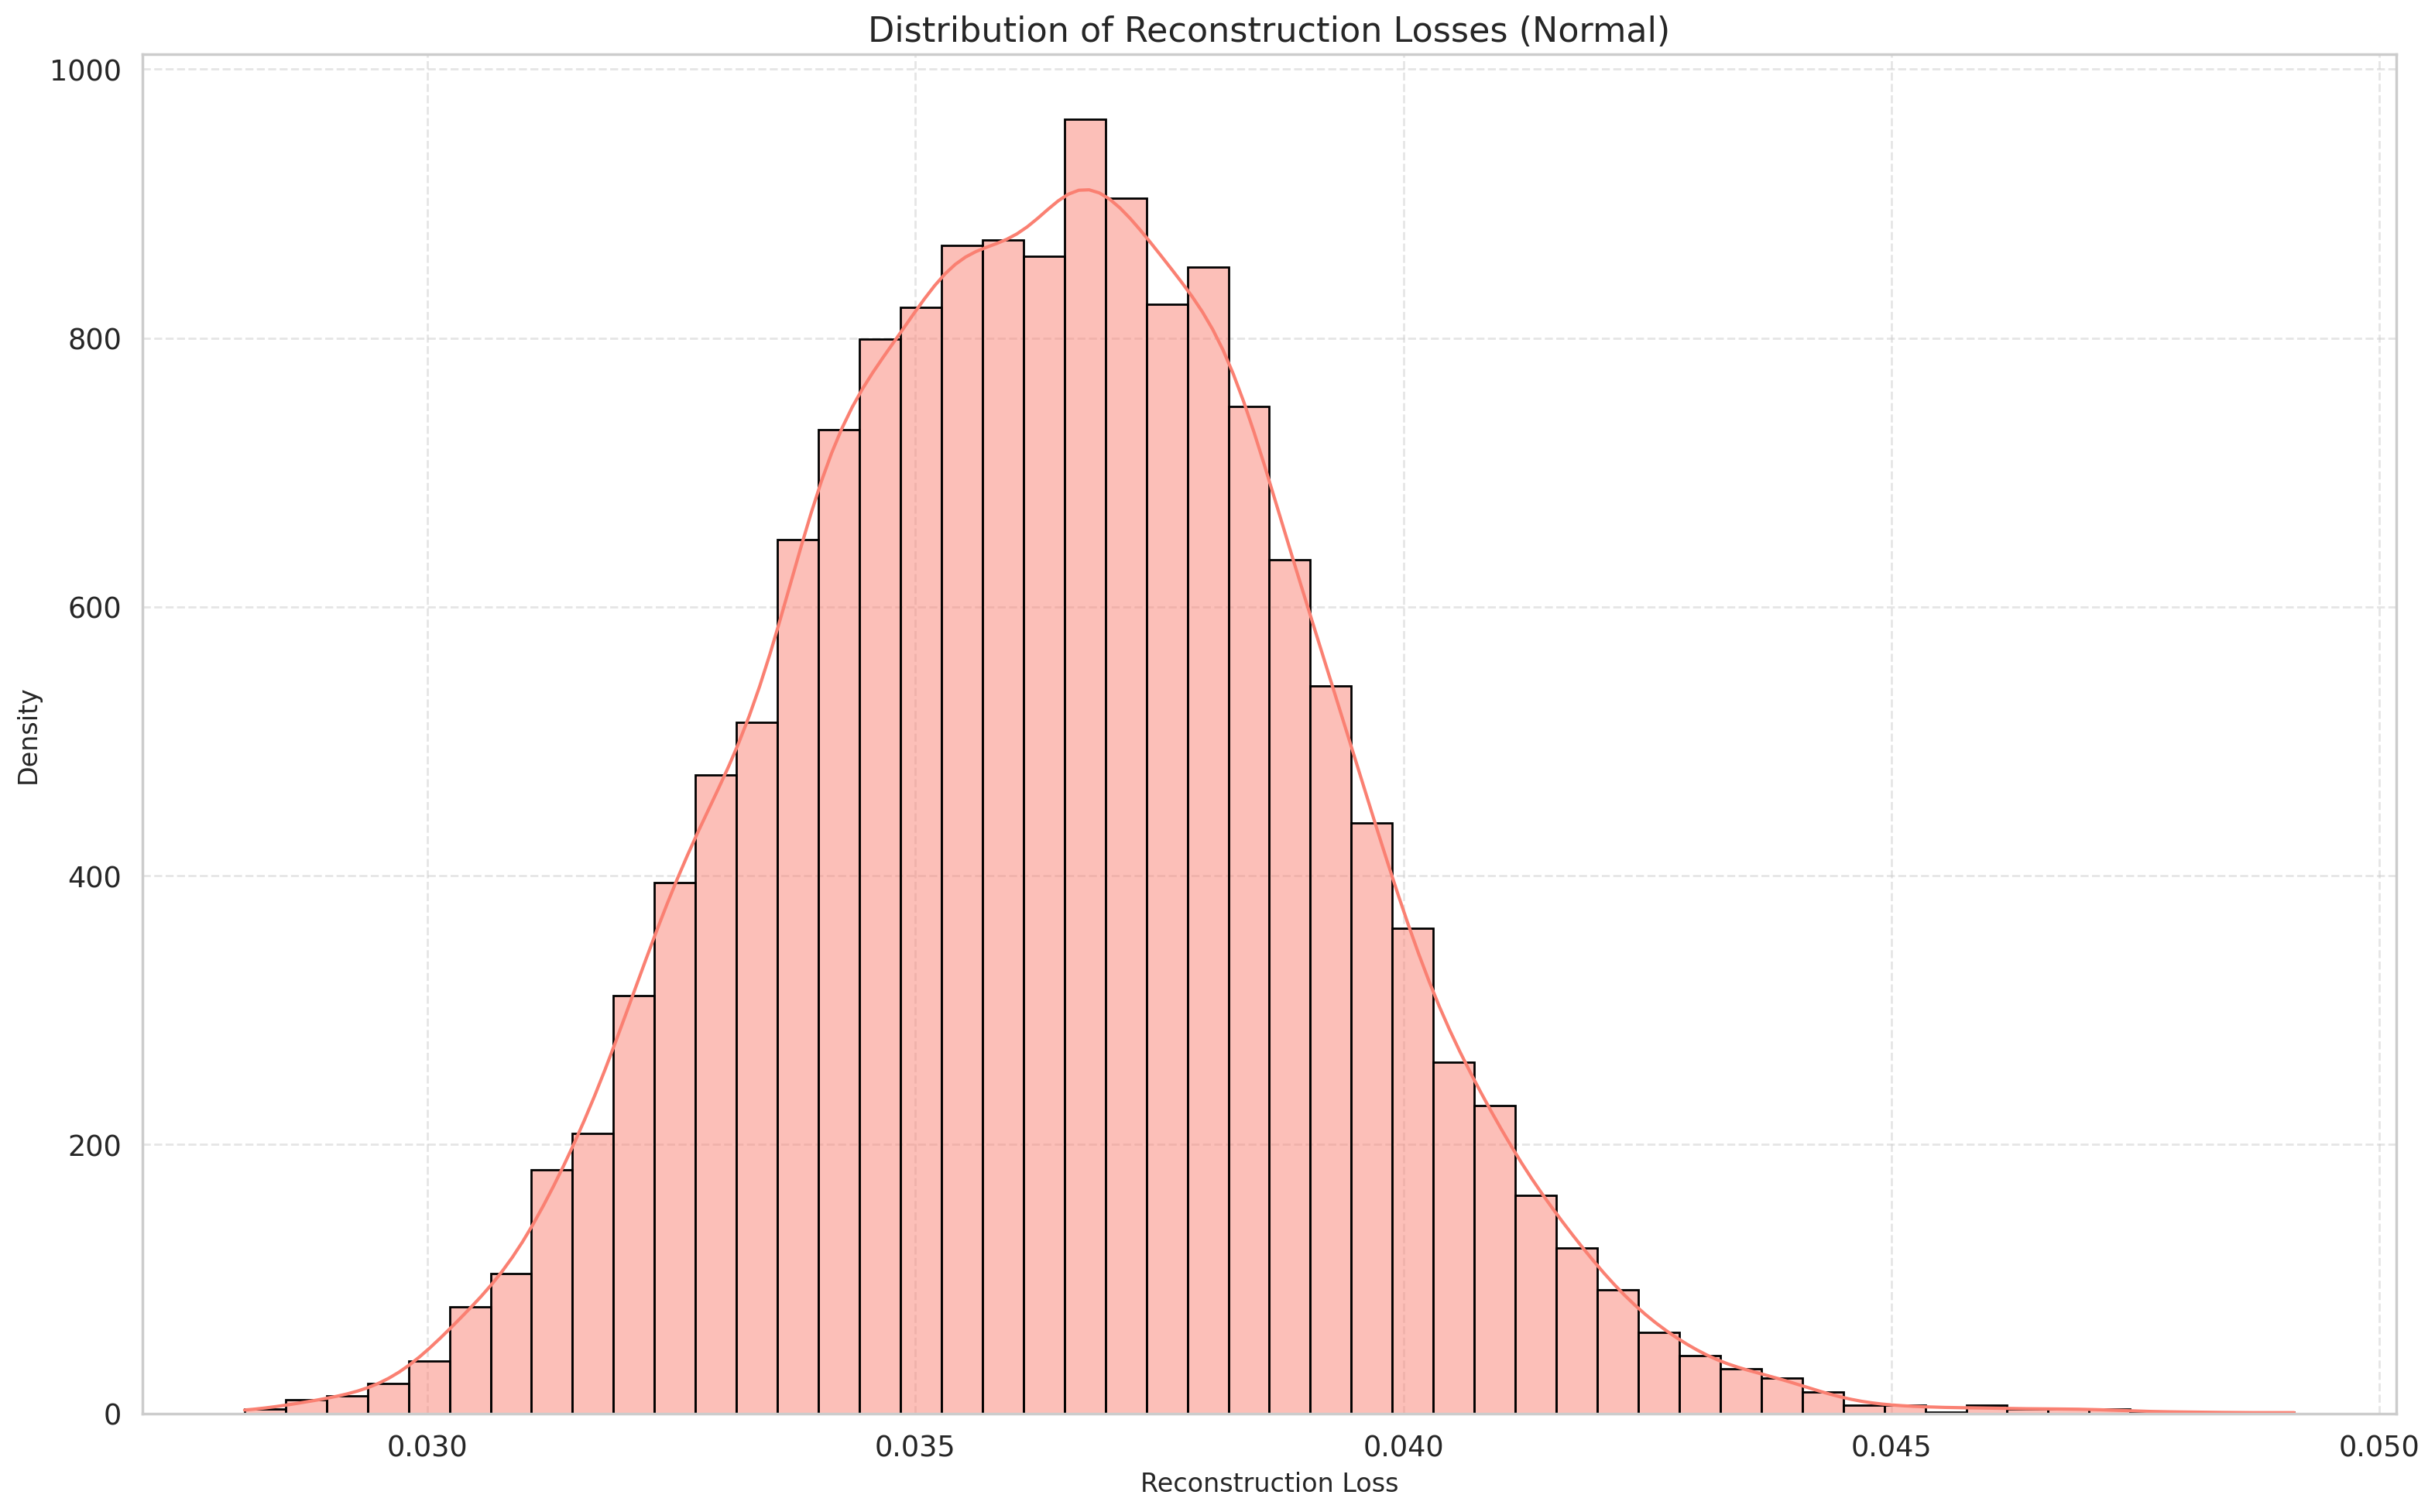

In [ ]:
sns.histplot(normal_losses, bins=50, kde=True, color='salmon', edgecolor='black')
plt.title('Distribution of Reconstruction Losses (Normal)', fontsize=16)
plt.xlabel('Reconstruction Loss', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

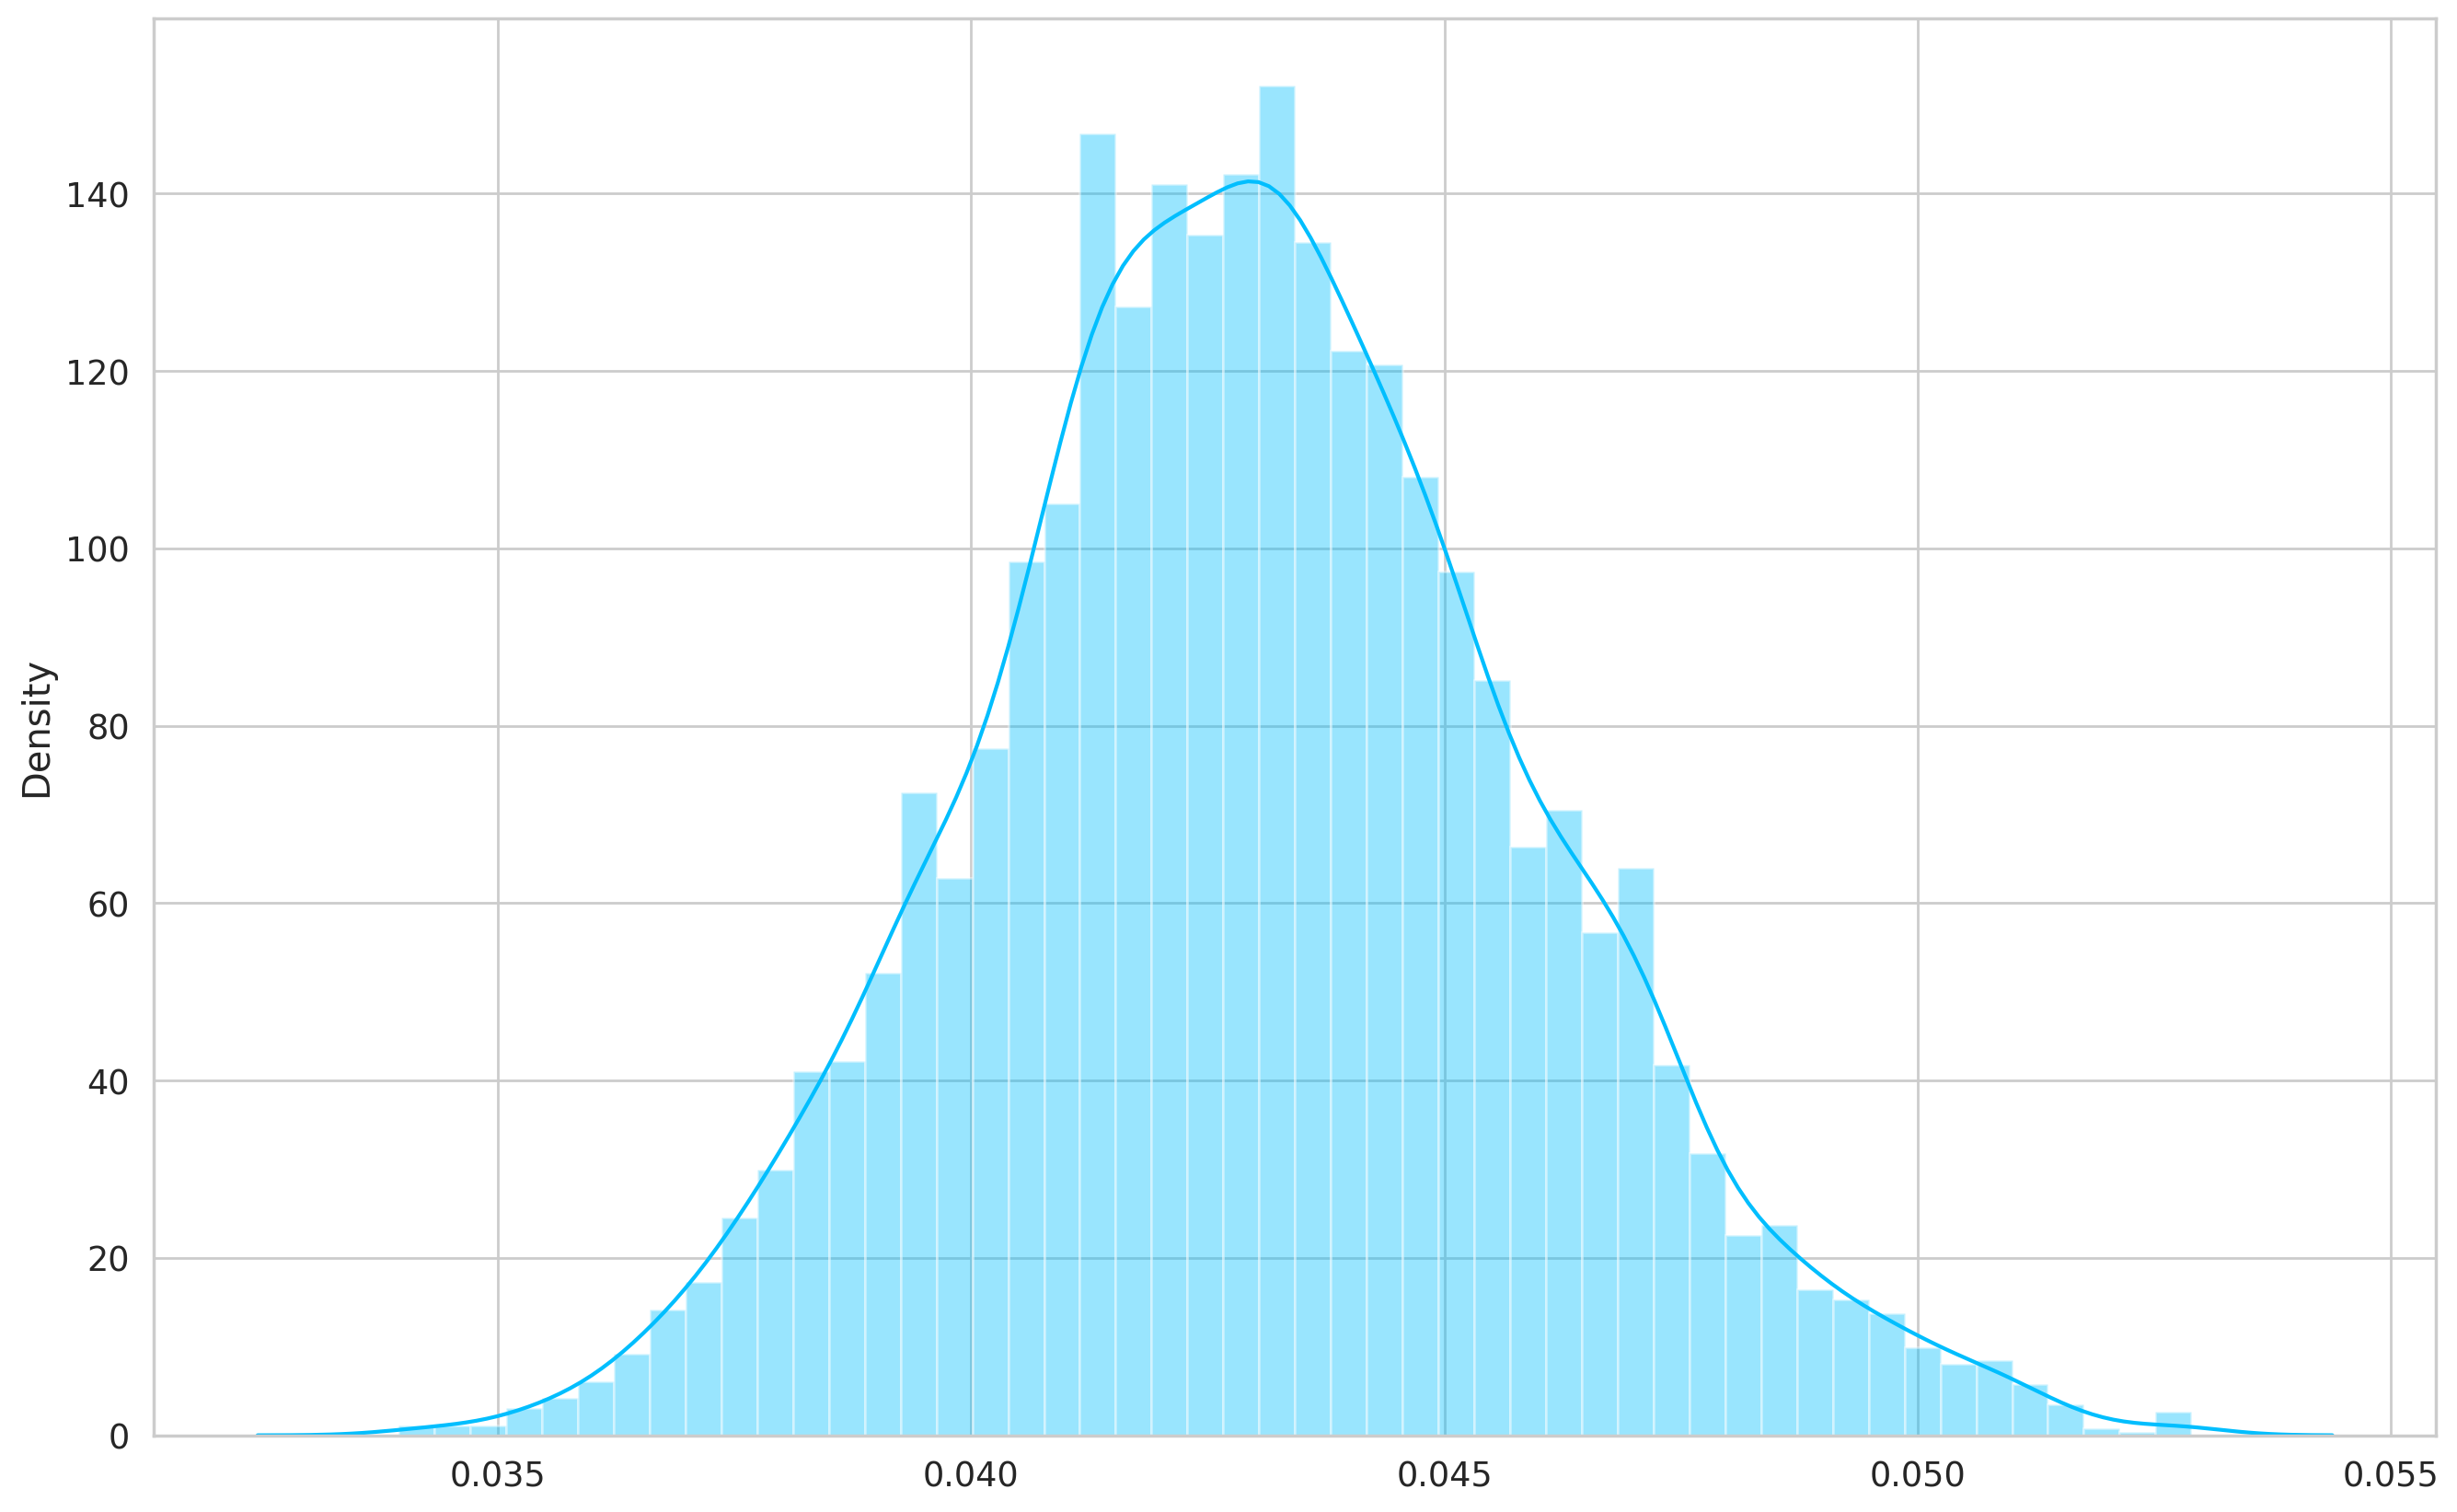

In [ ]:
sns.distplot(anomaly_losses, bins=50, kde=True);

In [ ]:
df_normal = df[df['label'] == 0].copy().reset_index(drop=True)
df_anomaly = df[df['label'] != 0].copy().reset_index(drop=True)

df_normal['loss'] = normal_losses
df_anomaly['loss'] = anomaly_losses

ValueError: Length of values (15307) does not match length of index (153651)

In [ ]:
# Optional: combine both for plotting
# df_combined = pd.concat([df_normal, df_anomaly]).sort_values(by='time')
# df_combined['anomaly_flag'] = df_combined['label'].apply(lambda x: 'Anomaly' if x != 0 else 'Normal')


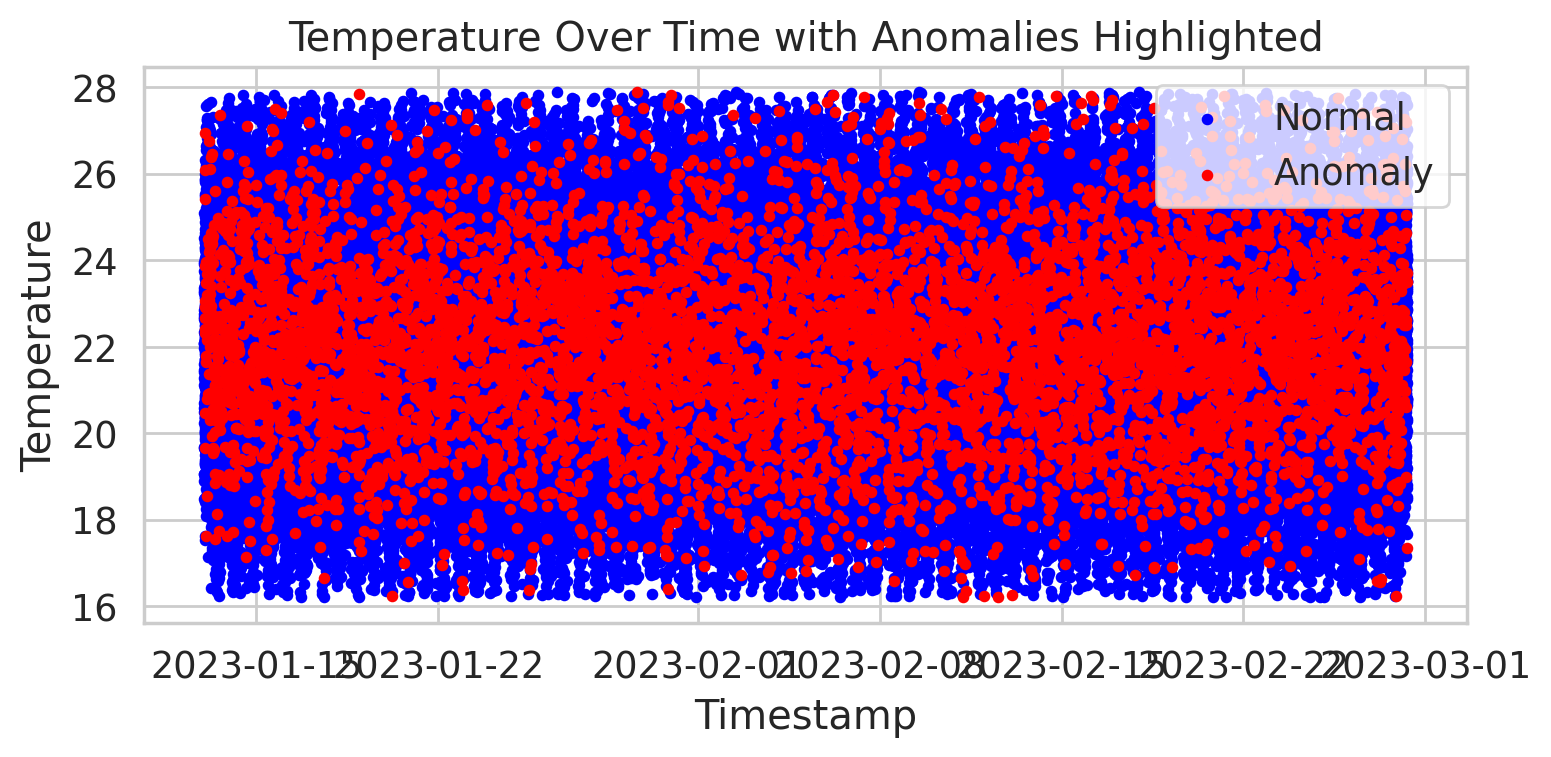

In [ ]:
plt.figure(figsize=(8, 4))

plt.scatter(df_normal['time'], df_normal['temperature'], color='blue', s=10, label='Normal')
plt.scatter(df_anomaly['time'], df_anomaly['temperature'], color='red', s=10, label='Anomaly')

plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.title("Temperature Over Time with Anomalies Highlighted")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
threshold = 0.041
# np.percentile(normal_losses, 98)

Combine Losses and True Labels for Evalution

In [ ]:
all_losses = normal_losses + anomaly_losses
y_true = [0] * len(normal_losses) + [1] * len(anomaly_losses)


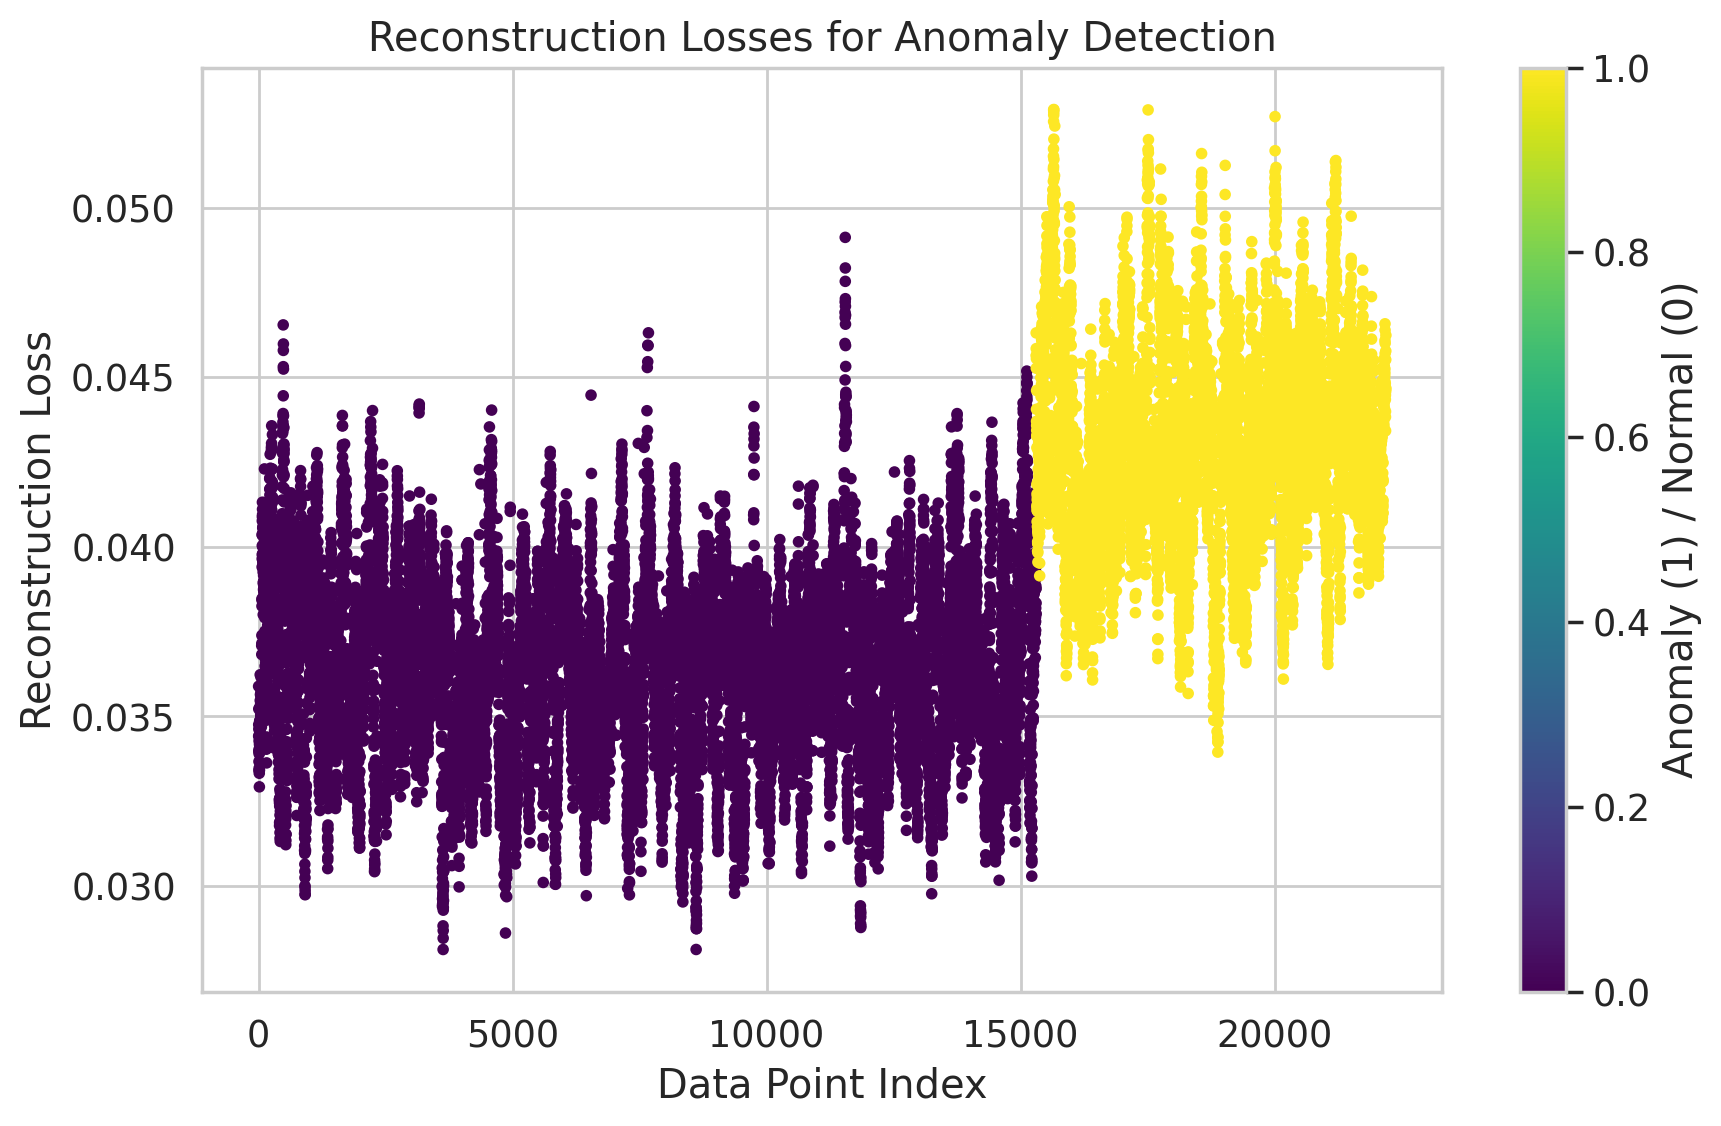

In [ ]:
# threshold = np.mean(all_losses[y_true == 0]) + 3 * np.std(all_losses[y_true == 0])

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(all_losses)), all_losses, c=y_true, cmap='viridis', marker='o', s=10)
plt.title('Reconstruction Losses for Anomaly Detection')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Loss')
plt.colorbar(label='Anomaly (1) / Normal (0)')
plt.grid(True)
plt.show()


Make Predictions

In [ ]:
y_pred = [1 if loss > threshold else 0 for loss in all_losses]

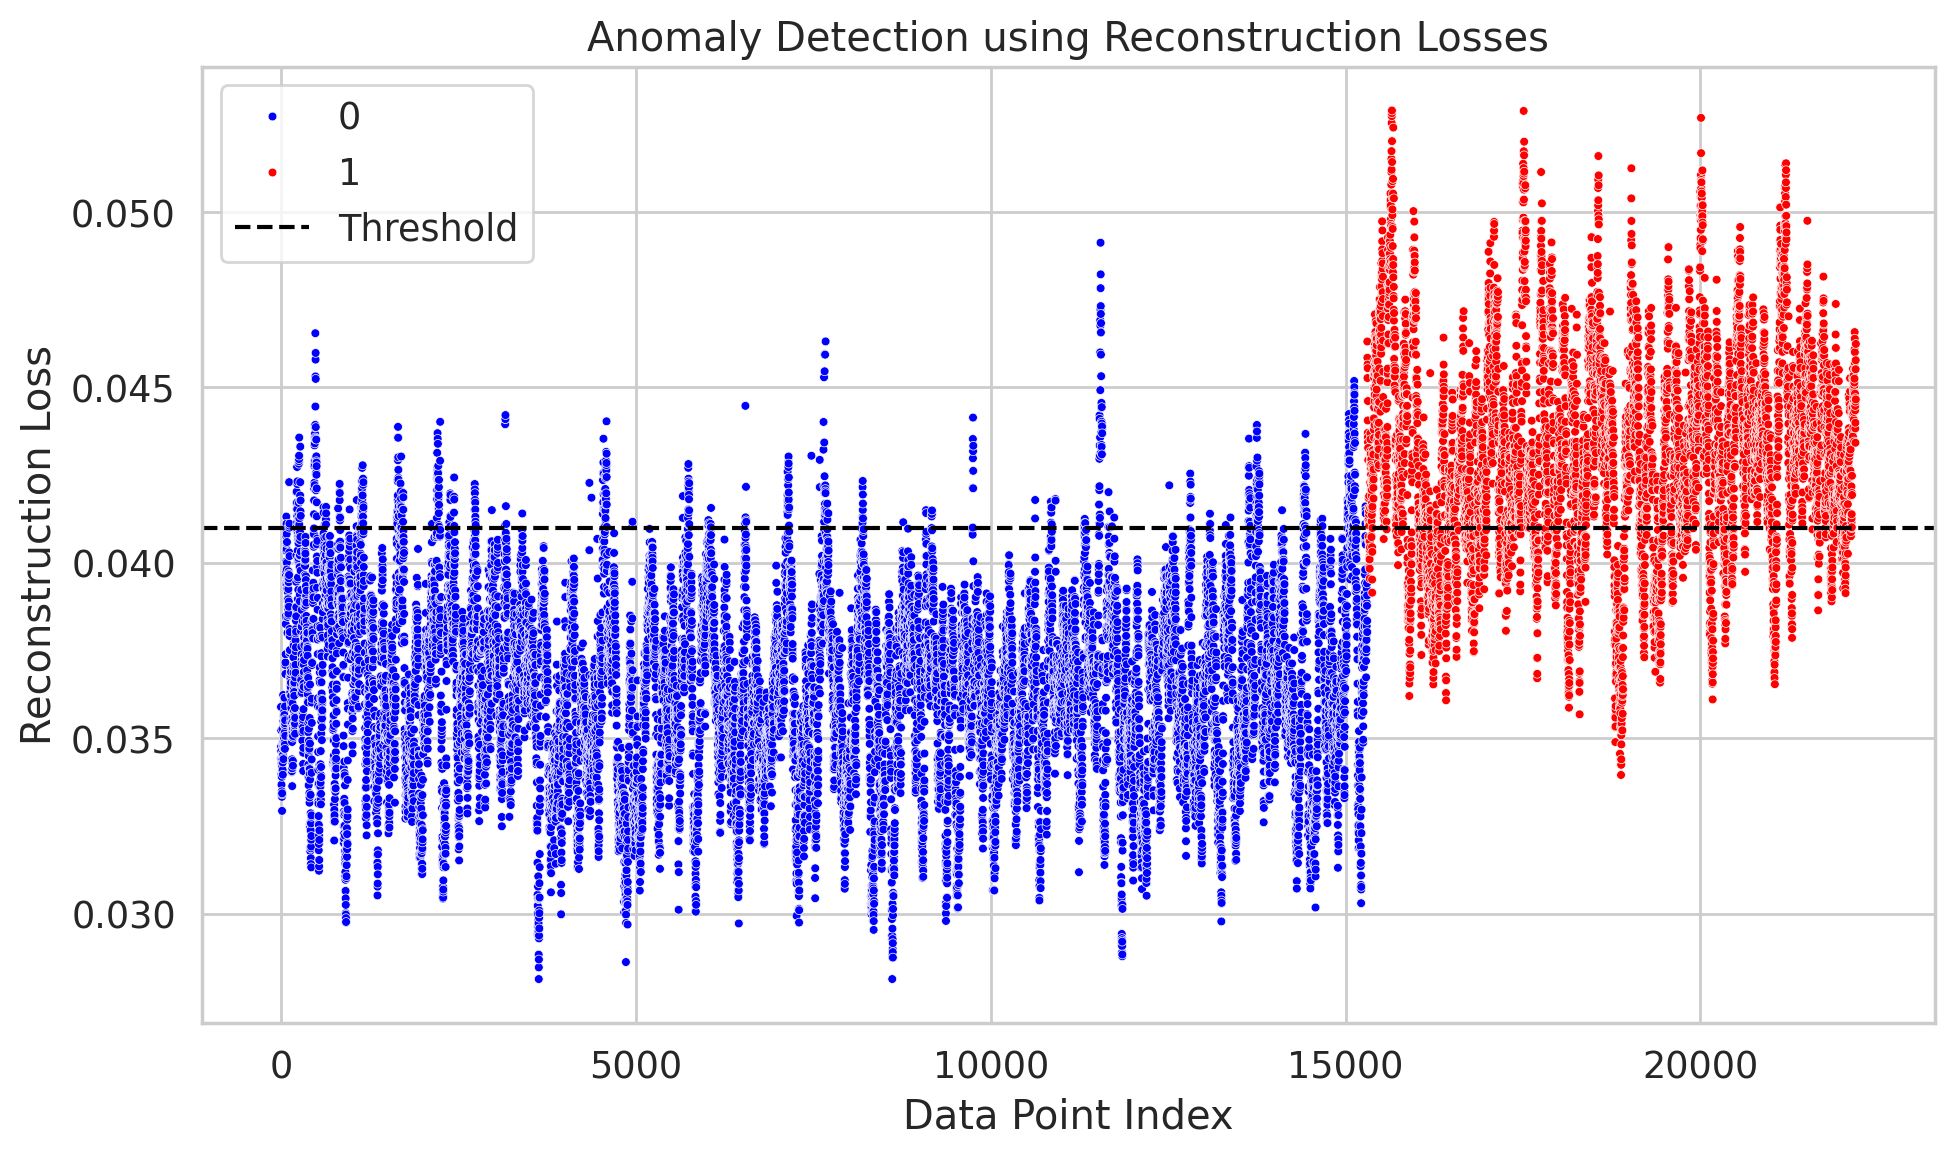

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(all_losses)), y=all_losses, hue=y_true,
                palette={0: 'blue', 1: 'red'}, s=10)
plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
plt.title('Anomaly Detection using Reconstruction Losses')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

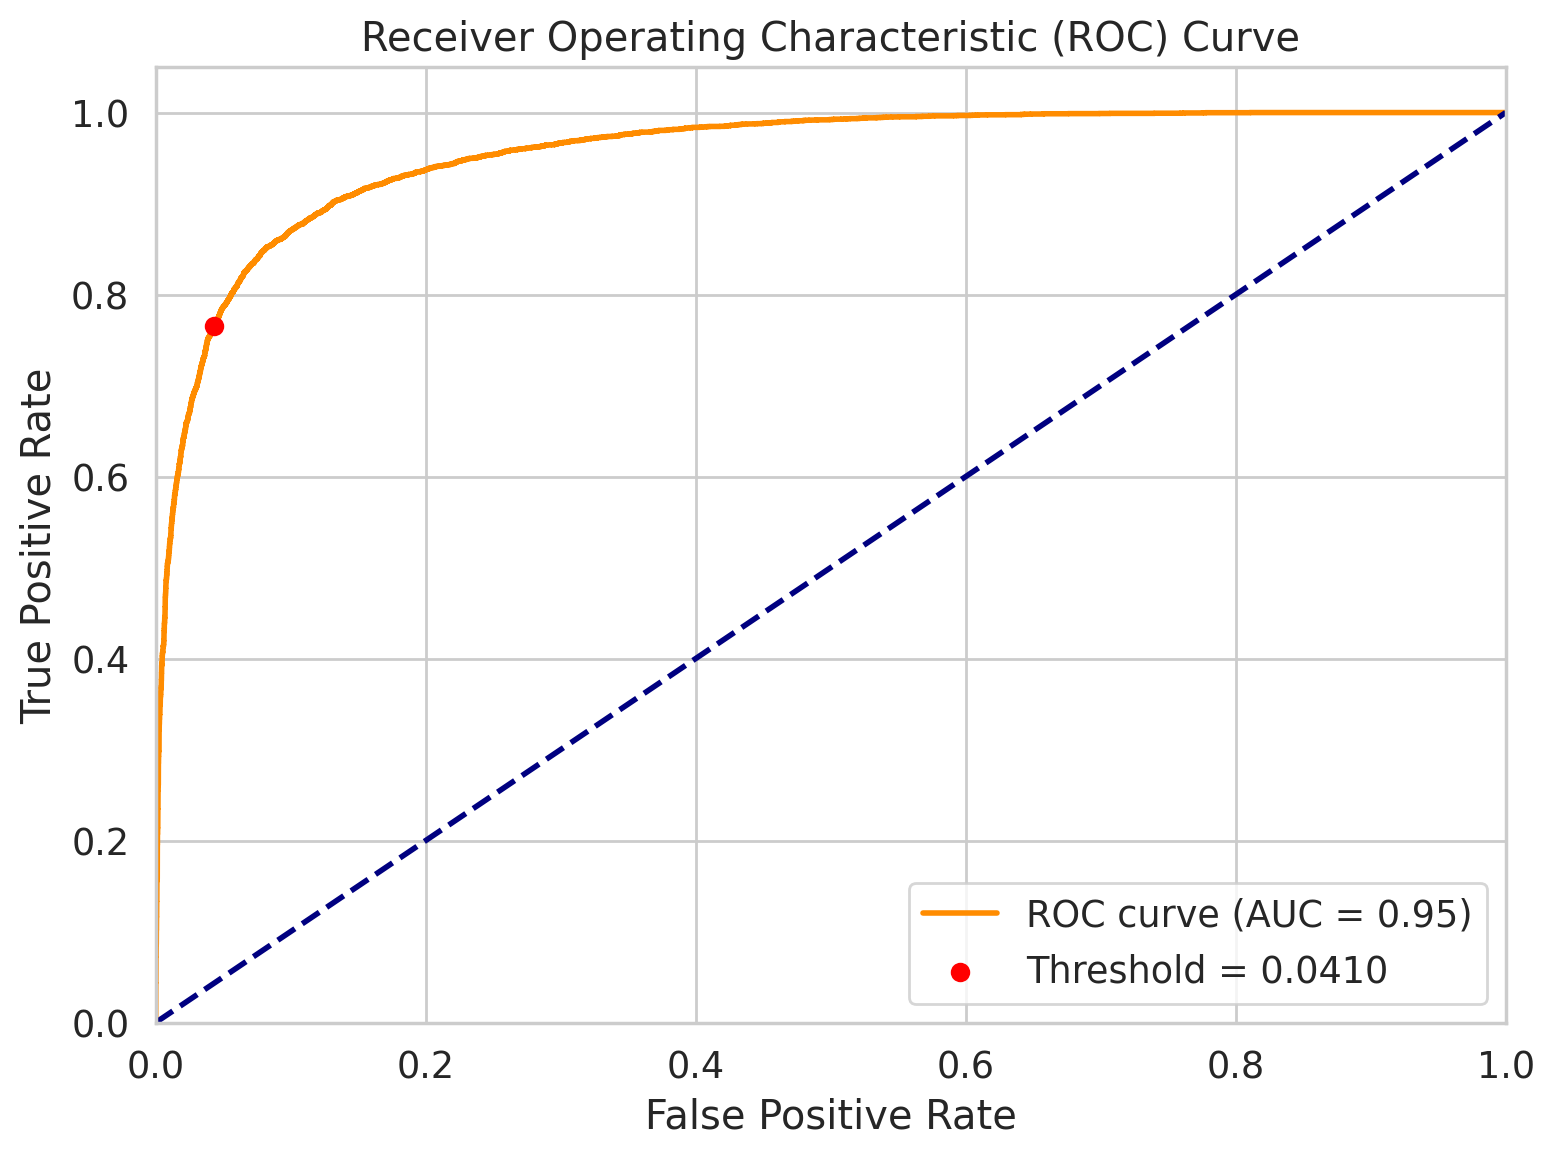

In [ ]:
# 1. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true, all_losses)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[np.argmin(np.abs(thresholds_roc - threshold))],
            tpr[np.argmin(np.abs(thresholds_roc - threshold))],
            color='red', label=f'Threshold = {threshold:.4f}', zorder=10)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

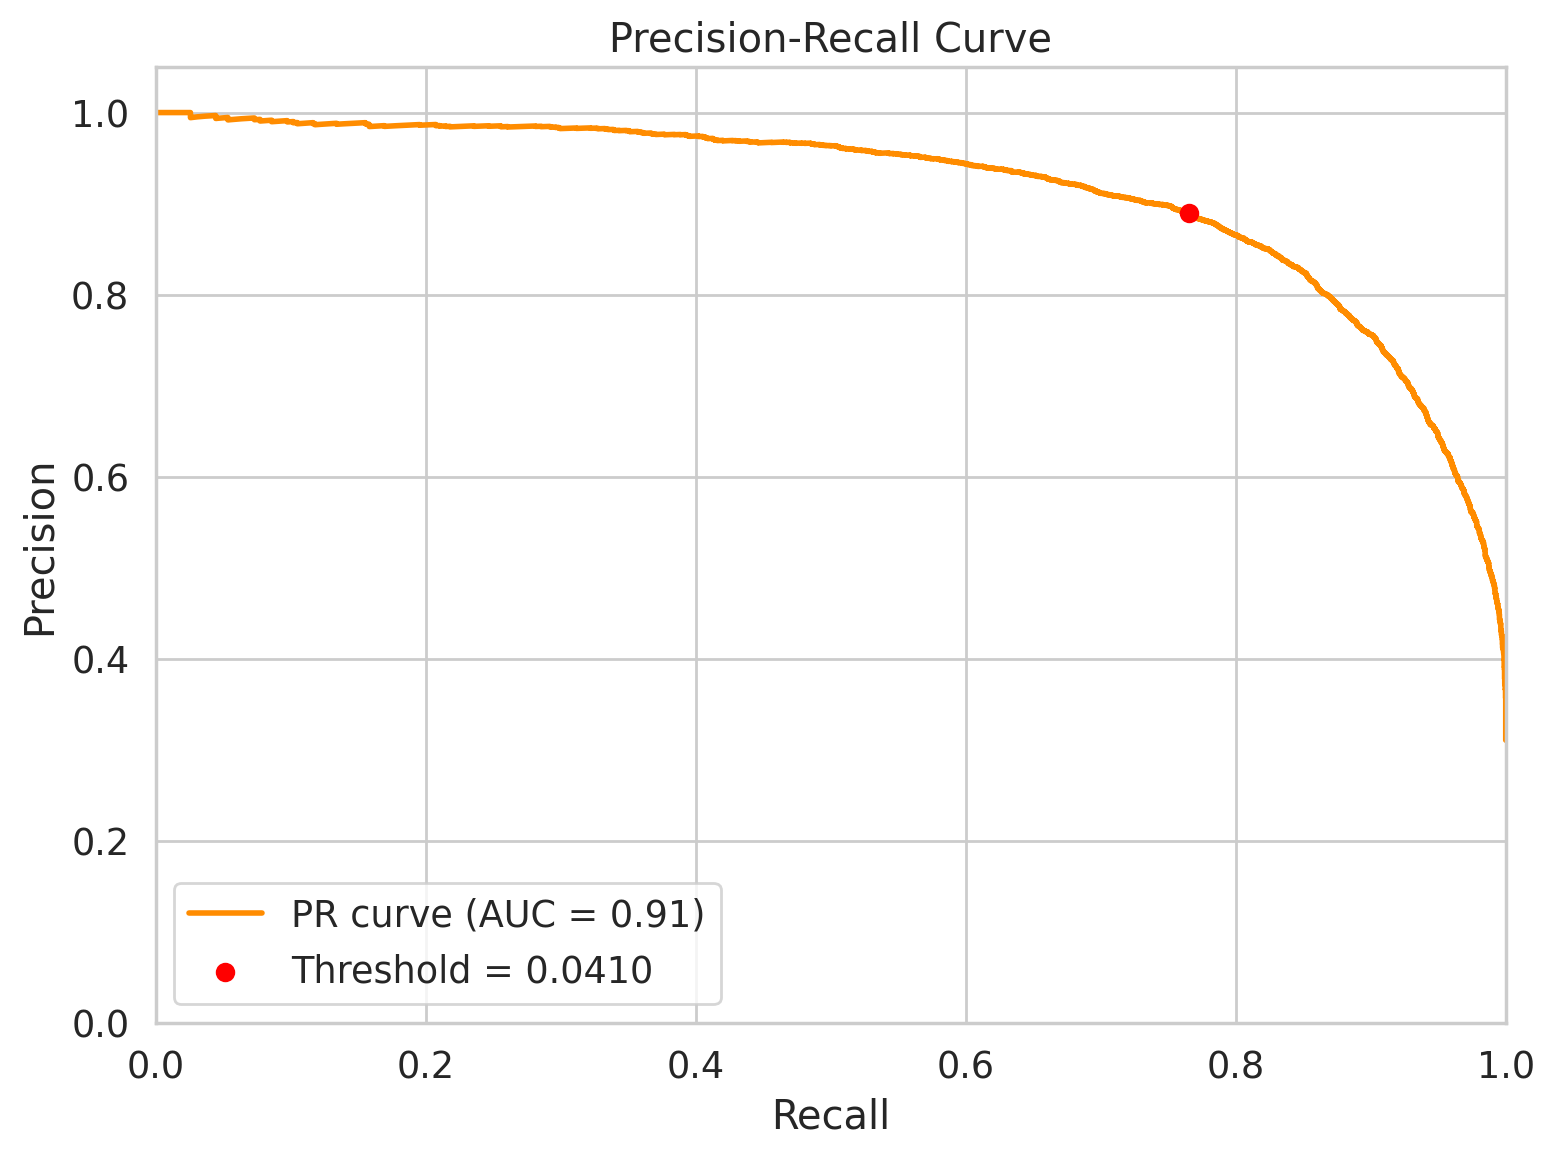

In [ ]:
# 2. Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_true, all_losses)
pr_auc = auc(recall, precision)

# Closest threshold index for PR curve
threshold_idx = np.argmin(np.abs(thresholds_pr - threshold))

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.scatter(recall[threshold_idx], precision[threshold_idx],
            color='red', label=f'Threshold = {threshold:.4f}', zorder=10)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

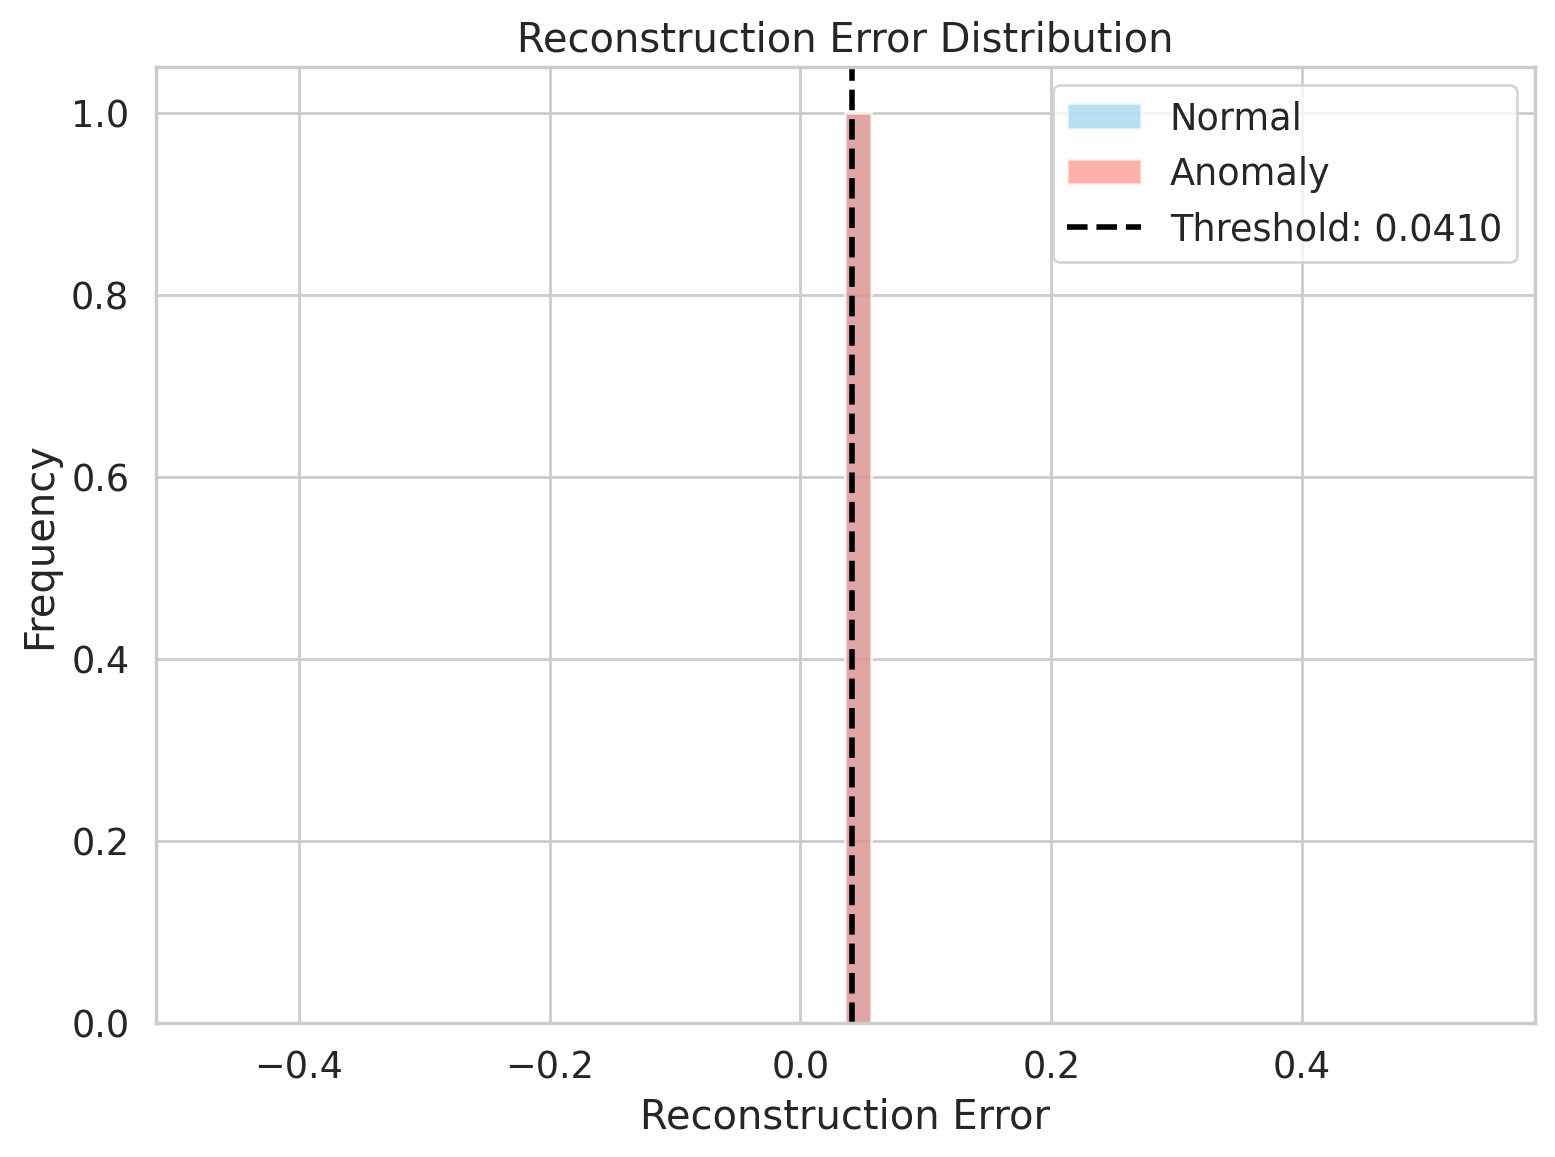

In [ ]:

# 3. Reconstruction Error Distribution (with Threshold)
plt.figure(figsize=(8, 6))
plt.hist(all_losses[y_true == 0], bins=50, color='skyblue', alpha=0.6, label='Normal')
plt.hist(all_losses[y_true == 1], bins=50, color='salmon', alpha=0.6, label='Anomaly')
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 4. Performance Summary
print("Model Evaluation at Threshold:", round(threshold, 5))
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'])
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

Model Evaluation at Threshold: 0.041
Confusion Matrix:
 [[14650   657]
 [ 1618  5267]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.90      0.96      0.93     15307
     Anomaly       0.89      0.76      0.82      6885

    accuracy                           0.90     22192
   macro avg       0.89      0.86      0.88     22192
weighted avg       0.90      0.90      0.90     22192



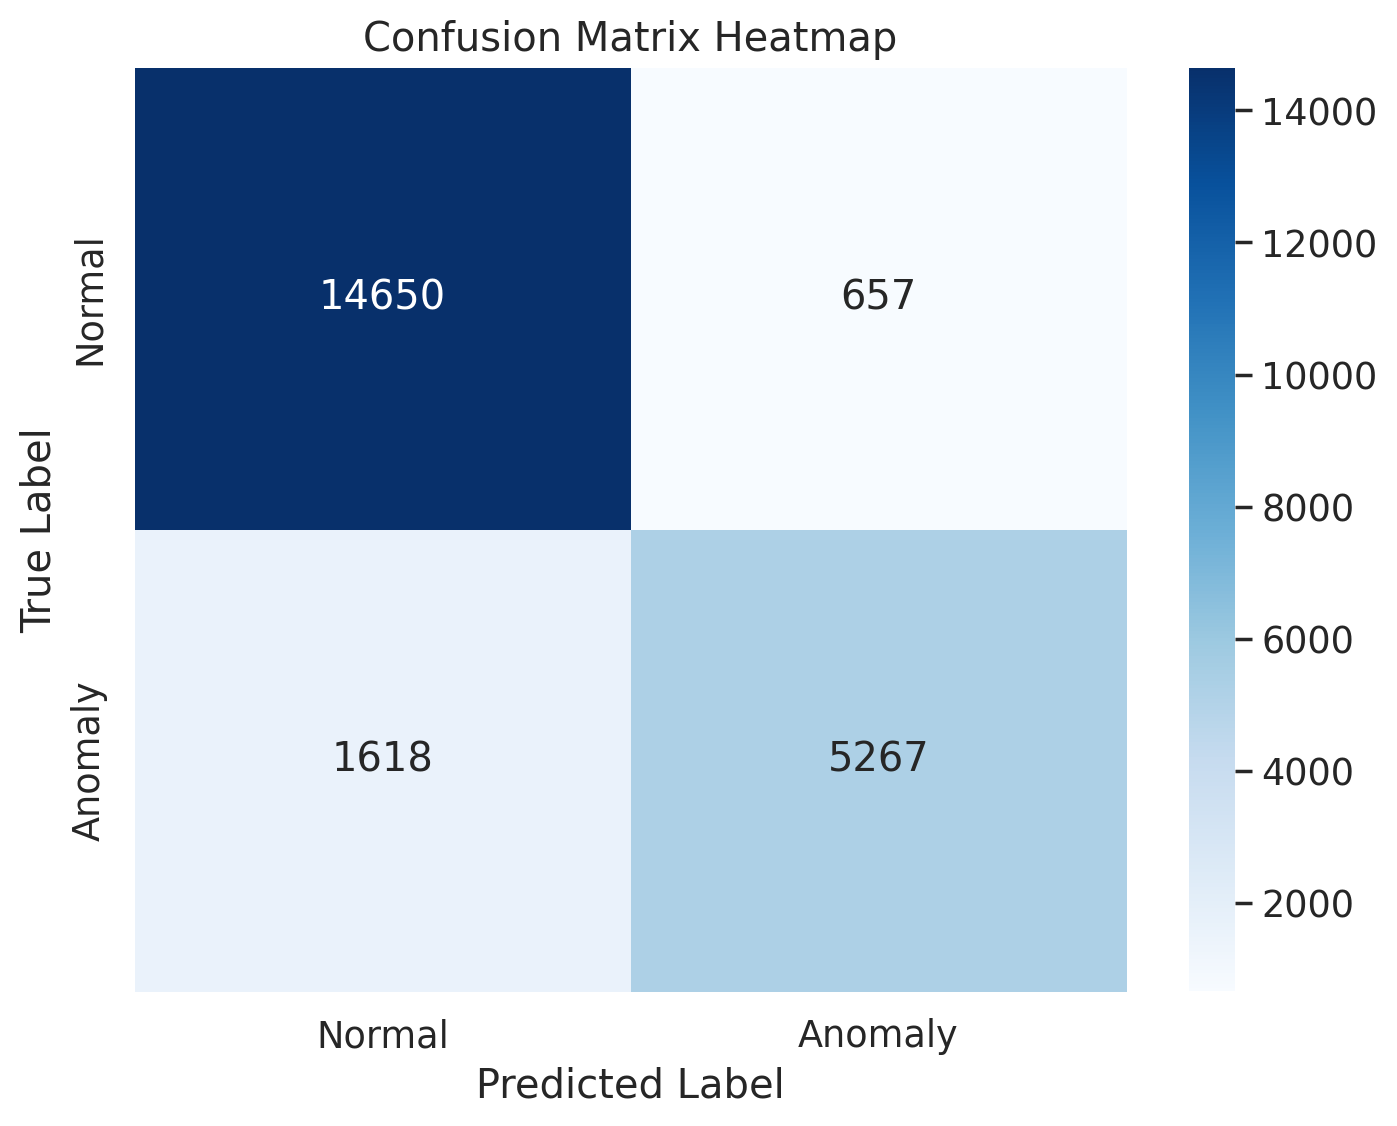

In [ ]:
confusion_matrix = np.array(
     [[14650,   657],
 [ 1618,  5267]]
)

class_names = ['Normal', 'Anomaly']

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

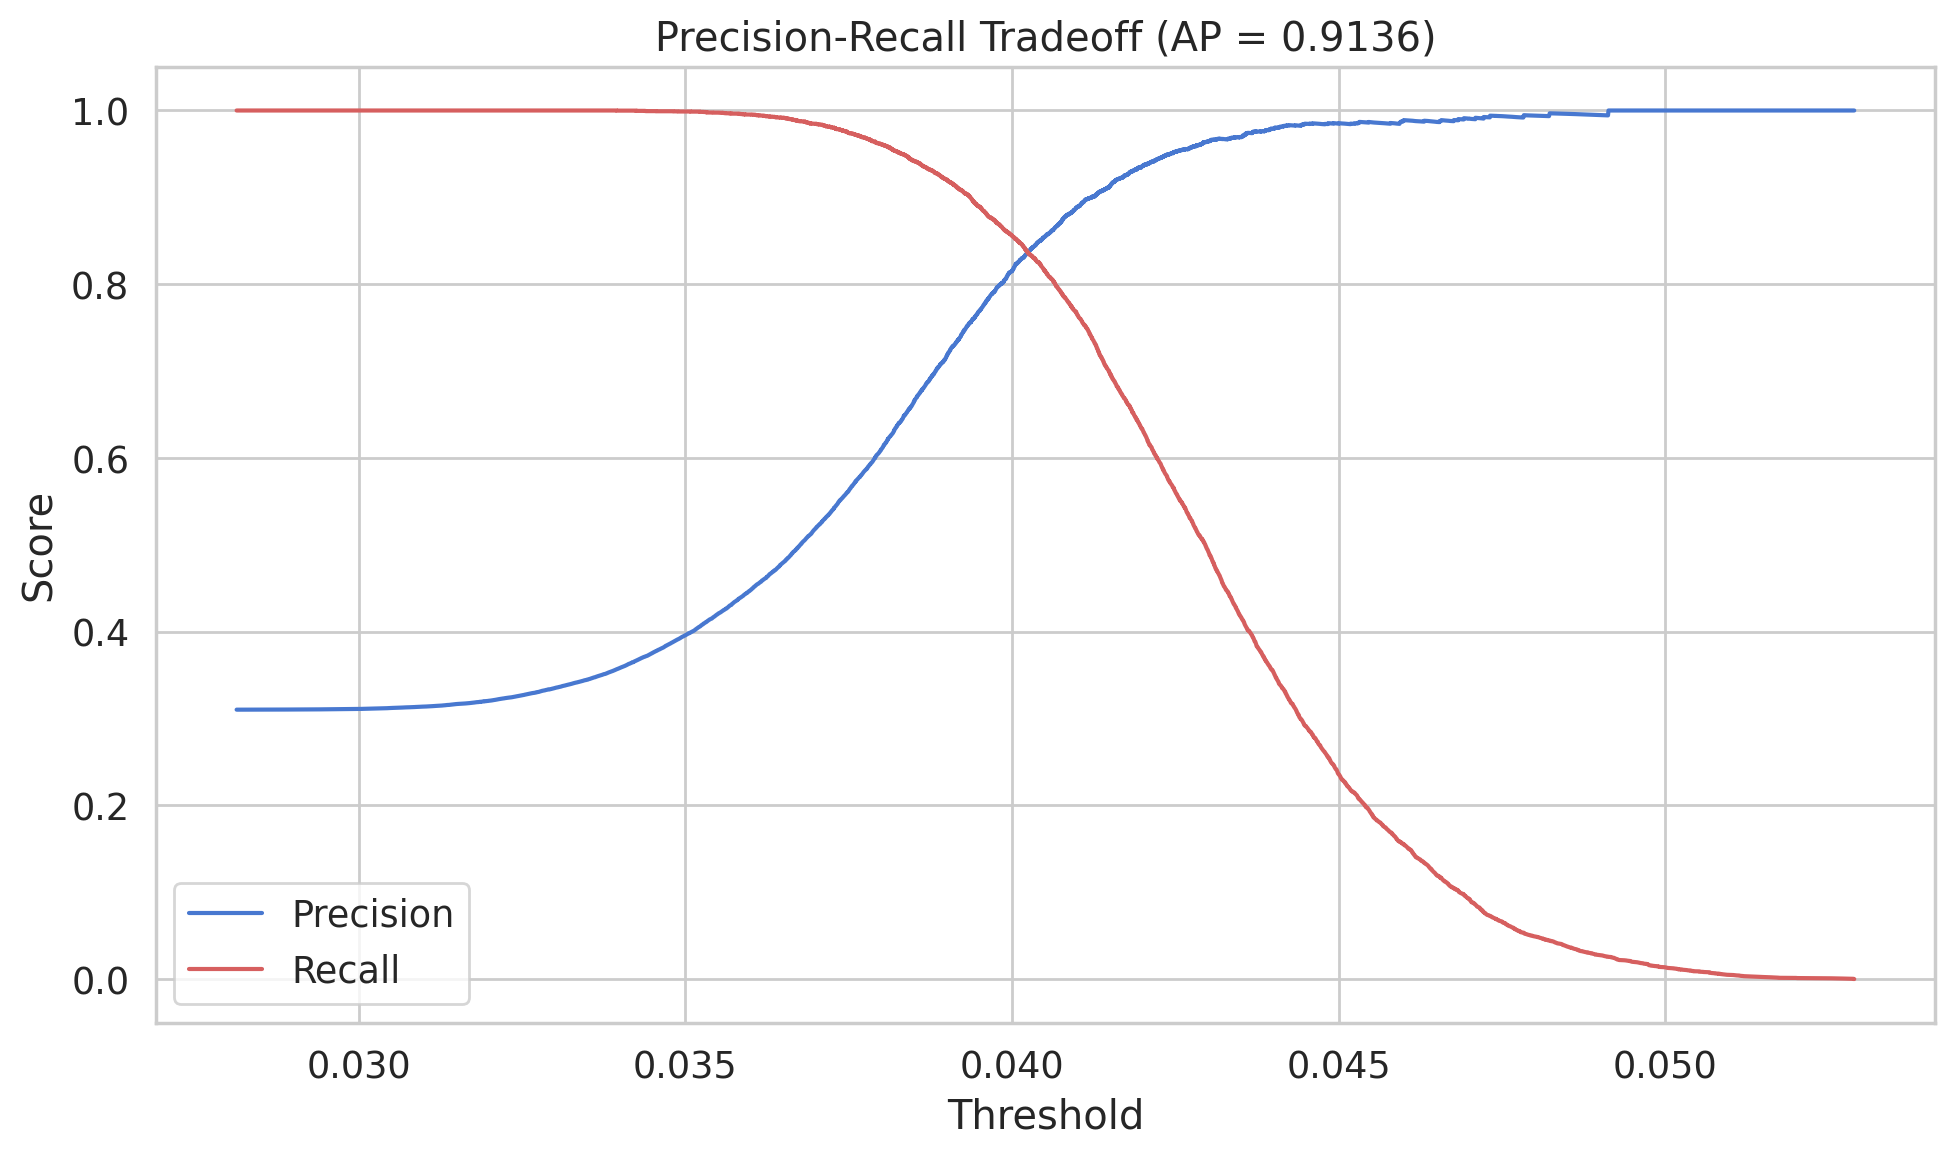

In [ ]:
from sklearn.metrics import average_precision_score
# Step 2: Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_true, all_losses)
avg_precision = average_precision_score(y_true, all_losses)


# Step 3: Plot the tradeoff
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='r')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'Precision-Recall Tradeoff (AP = {avg_precision:.4f})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Creating a Mapping

In [ ]:
label_encoder.classes_ = ['No Anomaly', 'equipment_failure', 'high_humidity', 'inefficient_routing',
                          'inventory_mismatch', 'temperature_spike', 'unauthorized_access', 'vibration_shock']

label_to_anomaly_type = {i: label for i, label in enumerate(label_encoder.classes_)}

In [ ]:
def detect_and_save_anomalies(model, dataloader, threshold, label_to_anomaly_type, df):
    anomalies = []
    criterion = nn.SmoothL1Loss(reduction='none').to(device)

    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            batch_data = batch[0].to(device)
            outputs = model(batch_data)
            losses = criterion(outputs, batch_data).mean(dim=(1, 2)).cpu().numpy()

            batch_start_index = batch_idx * batch_data.shape[0]
            max_loss_in_batch = max(losses)

            for i, loss in enumerate(losses):
                global_index = batch_start_index + i
                if global_index >= len(df):
                    continue

                row = df.iloc[global_index]
                predicted_label = 1 if loss > threshold else 0
                label_idx = int(row['label'])

                if predicted_label == 1:
                    anomaly_type = label_to_anomaly_type.get(label_idx, "unknown")
                    confidence = 1 - (loss / max_loss_in_batch)

                    print(f"[DEBUG] Detected Anomaly - Index: {global_index}, Label: {label_idx}, Type: {anomaly_type}")

                    anomalies.append({
                        'timestamp': pd.to_datetime(row['time']).isoformat() + "Z",
                        'sensor_id': row['sensor_id'],
                        'zone': row['zone'],
                        'predicted_label': predicted_label,
                        'anomaly_type': anomaly_type,
                        'confidence': round(confidence, 6)
                    })

    with open("anomalies.csv", "w", newline="") as csvfile:
        fieldnames = ["timestamp", "sensor_id", "zone", "predicted_label", "anomaly_type", "confidence"]
        writer = DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(anomalies)


In [ ]:
detect_and_save_anomalies(model, test_anomaly_loader, threshold, label_to_anomaly_type, df)

In [ ]:
if os.path.exists("anomalies.csv"):
    print("Anomalies CSV file created successfully!")
    anomalies_df = pd.read_csv("anomalies.csv")
    print(anomalies_df.head())

    num_anomalies = len(anomalies_df)
    print(f"Number of detected anomalies: {num_anomalies}")

    display(FileLink("anomalies.csv"))
else:
    print("Error: Anomalies CSV file not found.")

In [ ]:

FileLink("anomalies.csv")

In [ ]:
anomalies_df = pd.read_csv("anomalies.csv")

In [ ]:
# from IPython.display import FileLink
# from google.colab import files

# files.download("anomalies.csv")

In [ ]:
df_real_anomalies = anomalies_df[anomalies_df['anomaly_type'] != 'No Anomaly']
print(df_real_anomalies.head())

In [ ]:
print(df['label'].value_counts())

In [ ]:
plt.figure(figsize=(14, 6))
colors = {
    'equipment_failure': 'purple',
    'high_humidity': 'green',
    'temperature_spike': 'orange',
    'inventory_mismatch': 'brown',
    'unauthorized_access': 'cyan',
    'inefficient_routing': 'magenta',
    'vibration_shock': 'black'
}

# Filter anomalies only
for anomaly_type, color in colors.items():
    label = label_encoder.transform([anomaly_type])[0]
    subset = df_anomaly[df_anomaly['label'] == label]
    plt.scatter(subset['time'], subset['temperature'], label=anomaly_type, color=color, s=12)

plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.title("Anomaly Types Over Time")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
# Heatmap of zones vs anomaly count
zone_sensor = df_anomalies.groupby(['zone', 'sensor_id']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(zone_sensor, annot=True, fmt='d', cmap='Reds')
plt.title("Anomaly Frequency by Zone and Sensor")
plt.ylabel("Zone")
plt.xlabel("Sensor ID")
plt.show()

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='True')
  ax.plot(predictions[0], label='Predicted')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    figsize=(16, 6),
    sharex=True,
    sharey=True
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title="Normal", ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title="Anomaly", ax=axs[0, i])

plt.tight_layout()
plt.show()

In [ ]:
# Normal Prediction

predictions, hu  pred_lo-sses = predct(mdel, test_normal_loader)

In [ ]:
# sns.distplot(pred_losses, bins=50, kde=True);
plt.figure(figsize=(8, 6))

sns.histplot(pred_losses, bins=50, kde=True, color='skyblue', edgecolor='black')

plt.title('Reconstruction Loss Distribution on Prediction Set', fontsize=16)
plt.xlabel('Reconstruction Loss', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
correct_predictions = sum(l <= threshold for l in pred_losses)
print(f"Correct Normal Predictions: {correct_predictions}/{len(pred_losses)}")


In [ ]:
sns.histplot(pred_losses, bins=50, kde=True, color='skyblue', edgecolor='black')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.5f}')
plt.title('Distribution of Reconstruction Losses (Test Normal)')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Count')
plt.legend()
plt.show()

Anomalies

In [ ]:
test_anomaly_loader = DataLoader(test_anomaly_loader, batch_size=batch_size)
predictions, pred_losses = predict(model, test_anomaly_loader)

In [ ]:
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct_predictions = sum(1 > threshold for l in pred_losses)
print(f"Correct Anomaly Predictions: {correct_predictions}/{len(test_anomaly_loader)}")

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='True')
  ax.plot(predictions[0], label='Predicted')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)f})')
  ax.legend()

In [ ]:
fig, axs = plt.subplots(
    nrows =2,
    ncols=6,
    figsize=(16, 6),
    sharex=True,
    sharey=True
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title="Normal", ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title="Anomaly", ax=axs[0, i])

plt.tight_layout()
plt.show()

Dataset

Detection